# 0.0 Imports

In [70]:
import pandas      as pd
import numpy       as np
import seaborn     as sns
import boruta      as bt
import scikitplot  as skplt
import pickle 
import xgboost     as xgb
import random


from matplotlib              import pyplot          as plt
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing   as pp
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from tabulate                import tabulate

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 14]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
#Cramer's V

def cramer(x,y):
    cm = pd.crosstab(x,y).values
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    n = cm.sum()
    
    r,k = cm.shape
    
    v = np.sqrt((chi2/n) / (min(k-1,r-1)))
    
    phi2 = chi2/n
    
    phi2corr = max(0,(phi2 - ((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1,rcorr-1)))

#METRCIS FUNCTIONS

def table_analysis(y_val,yhat):
    table = pd.DataFrame(y_val)
    table['id'] = y_val.index + 1
    table['predict_score'] = yhat[:,1].tolist()
    table = table.sort_values('predict_score',ascending=False)
    table = table.reset_index(drop=True)
    table['ranking'] = table.index + 1
    table['acc_pred_score'] = table['response'].cumsum()/table['response'].sum()
    table['base'] = table['ranking']/len(table)
    table['baseline'] = table['base'] 
    table['lift'] = table['acc_pred_score'] / table['baseline']
    table['precision_at_k'] = table['response'].cumsum()/table['ranking']
    table['recall_at_k'] = table['response'].cumsum()/table['response'].sum()
    order_cols = ['id','response','predict_score','ranking','acc_pred_score','base','baseline','lift','precision_at_k','recall_at_k']
    table = table[order_cols]
    
    return table

def precision_recall_at_k (table, k=100):
    #data = data.sort_values('predict_score',ascending=False)
    #data = data.reset_index(drop=True)
    #data['ranking'] = data.index+1
    table['precision_at_k'] = table['response'].cumsum()/table['ranking']
    table['recall_at_k'] = table['response'].cumsum()/table['response'].sum()
    
    return pd.DataFrame({'precision_at_k':table.loc[k-1,'precision_at_k'],'recall_at_k': table.loc[k-1,'recall_at_k']},index=[k])

def precision_recall_at_k_2 (table, k=100):
    #data = data.sort_values('predict_score',ascending=False)
    #data = data.reset_index(drop=True)
    #data['ranking'] = data.index+1
    table['precision_at_k'] = table['response'].cumsum()/table['ranking']
    table['recall_at_k'] = table['response'].cumsum()/table['response'].sum()
    
    return ({table.loc[k-1,'precision_at_k'],table.loc[k-1,'recall_at_k']})


def cross_validation(data, model, name_model, n_splits, n_repeats, top_k):
    X = data.drop('response',axis=1)
    y = data['response']
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    i = 1
    metrics_k = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        print ('\nKFold Number: {}'.format( i ) )
        i+=1
        
        #print('training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
        
        #model training
        ml_model = model.fit(X_train,y_train)
        
        #prediction
        yhat = ml_model.predict_proba(X_val)
        
        #performance
        result_model = table_analysis(y_val,yhat)
        #metrics_k = metrics_k.append(precision_recall_at_k(result_model,top_k))
        metrics_k = pd.concat([metrics_k,precision_recall_at_k(result_model,top_k)],axis=0)
        
    
    
    real_performance = pd.DataFrame({
        #'Name_Model': name_model,
        'Mean_Precision_at_k' : str((np.round((metrics_k['precision_at_k'].mean()),5)))+ '+/-'+str((np.round((metrics_k['precision_at_k'].std()),5))),
        'Mean_Recall_at_k': str((np.round((metrics_k['recall_at_k'].mean()),5)))+ '+/-'+str((np.round((metrics_k['recall_at_k'].std()),5)))
    }, index = [name_model])        
        
    
    return real_performance

# 0.2. Loading Dataset

In [3]:
df_raw = pd.read_csv('C:/Users/kaka/Projetos_DS/health-insurance-cross-sell/data/raw/train.csv')

In [3]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Descripition

In [4]:
df_raw.columns

cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1 = df_raw.copy()
df1.columns = cols_new

## 1.1 Data Dimension

In [5]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [4]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [5]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [6]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes,', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,"attributes,",min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [6]:
df2 = df1.copy()

In [7]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                                       if x == '1-2 Year'  else 'below_1_year')


#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [16]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


# 3.0. Data Filtering

In [29]:
df3 = df2.copy()

# 4.0. EDA

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

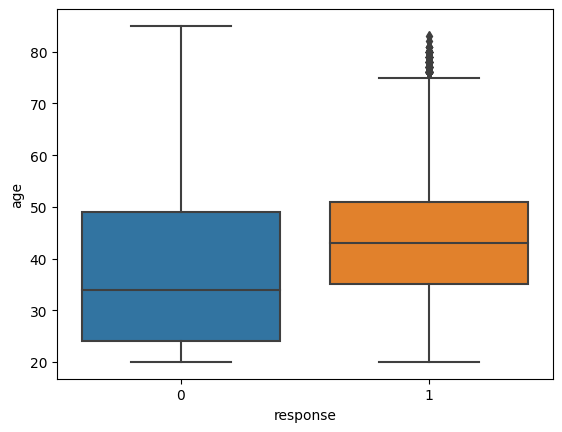

In [27]:
#'age'
sns.boxplot( x = 'response', y = 'age', data=df4);

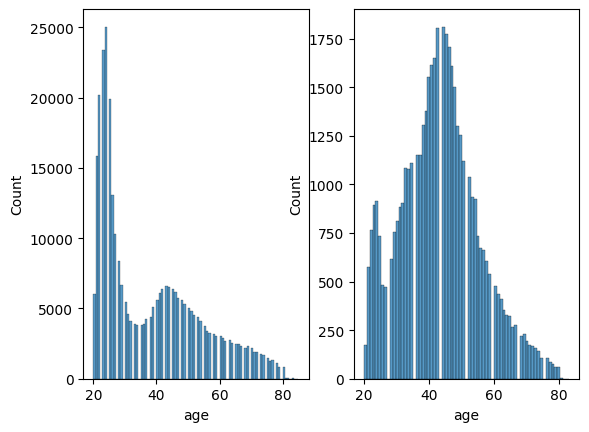

In [28]:
aux00 = df4.loc[df4['response'] == 0, 'age']
plt.subplot(1, 2, 1)
sns.histplot(aux00);

aux01 = df4.loc[df4['response'] == 1, 'age']
plt.subplot(1, 2, 2)
sns.histplot(aux01);

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

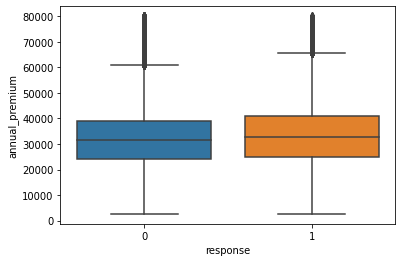

In [41]:
#'annual_premium'   
aux = df4[df4['annual_premium'] < 80000]

sns.boxplot( x = 'response', y = 'annual_premium', data=aux)



<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

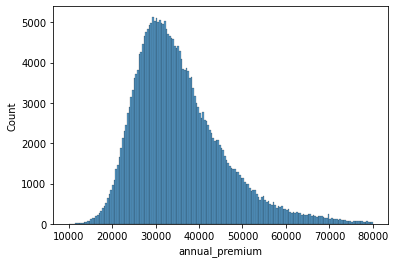

In [48]:
aux =df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

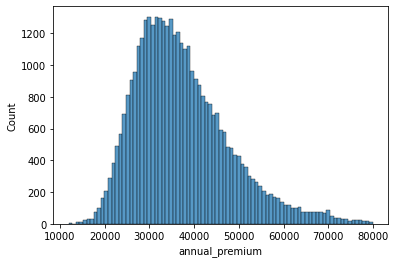

In [18]:
aux =df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux01)

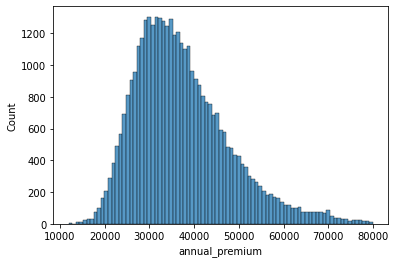

In [20]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

<AxesSubplot:xlabel='response', ylabel='driving_license'>

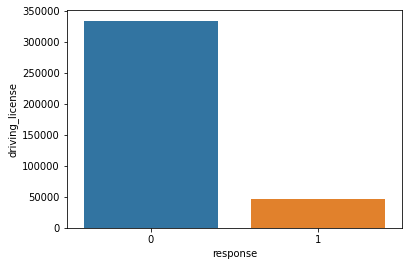

In [45]:
#'driving_license'
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data = aux)

<AxesSubplot:xlabel='region_code', ylabel='id'>

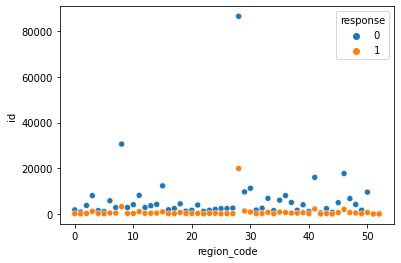

In [54]:
#'region_code'
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x = 'region_code', y='id', hue='response', data=aux0)

In [22]:
#'vehicle_damage'

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 1)

response,0,1
vehicle_damage,,
0,99.48,0.52
1,76.23,23.77


In [12]:
aux00 =df4.groupby(['vehicle_damage','response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

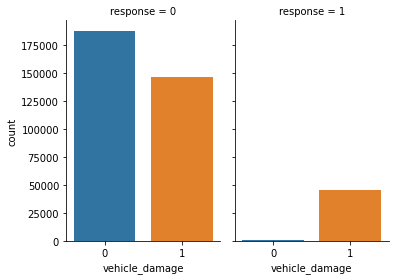

In [13]:
g = sns.catplot(x="vehicle_damage", y="count",col="response",
                data=aux00, kind="bar",
                height=4, aspect=.7);

In [41]:
#'previously_insured'
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [40]:
#'vehicle_age'
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 1)

response,0,1
vehicle_age,,
below_1_year,95.63,4.37
between_1_2_year,82.62,17.38
over_2_years,70.63,29.37


In [14]:
aux00 =df4.groupby(['vehicle_age','response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

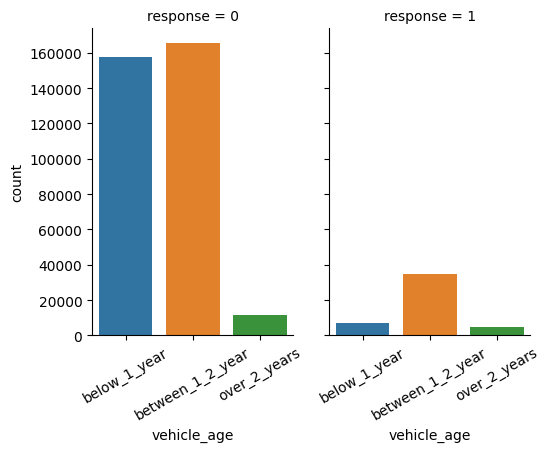

In [26]:
g = sns.catplot(x="vehicle_age", y="count",col="response",
                data=aux00, kind="bar",
                height=4, aspect=.7);

g.set_xticklabels(rotation=30);

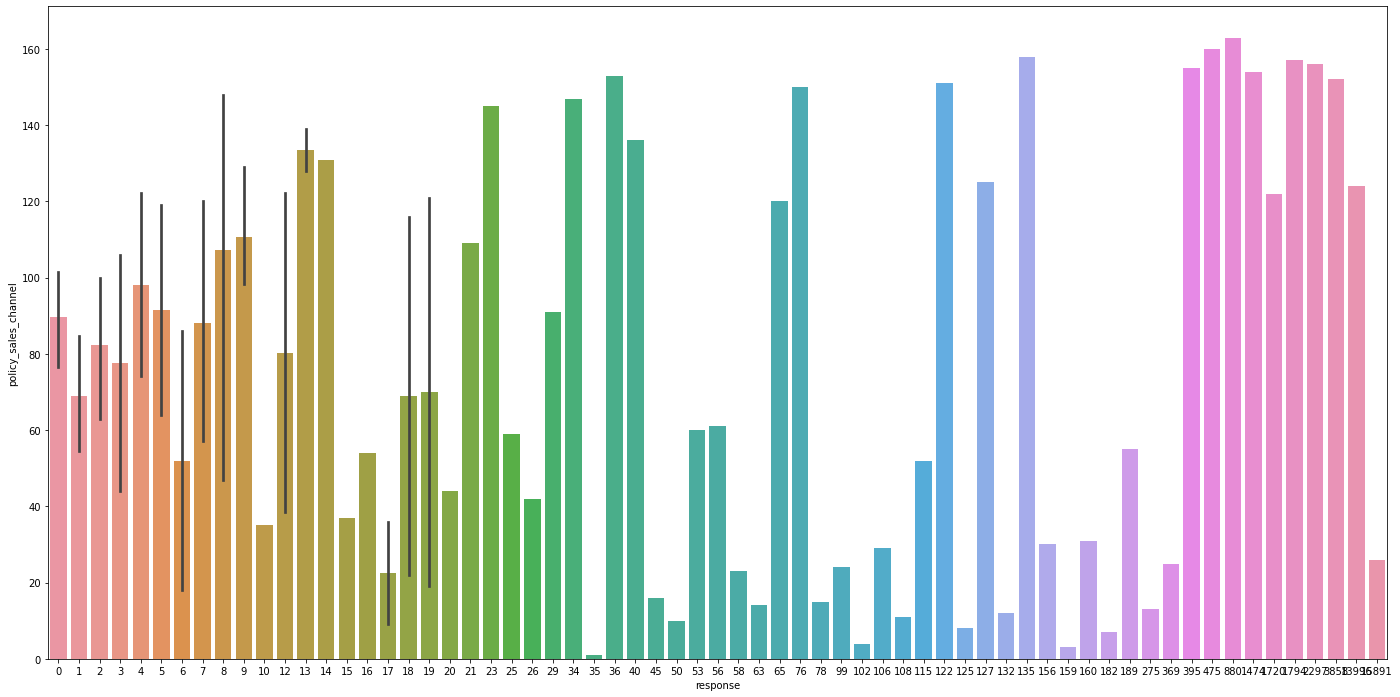

In [47]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

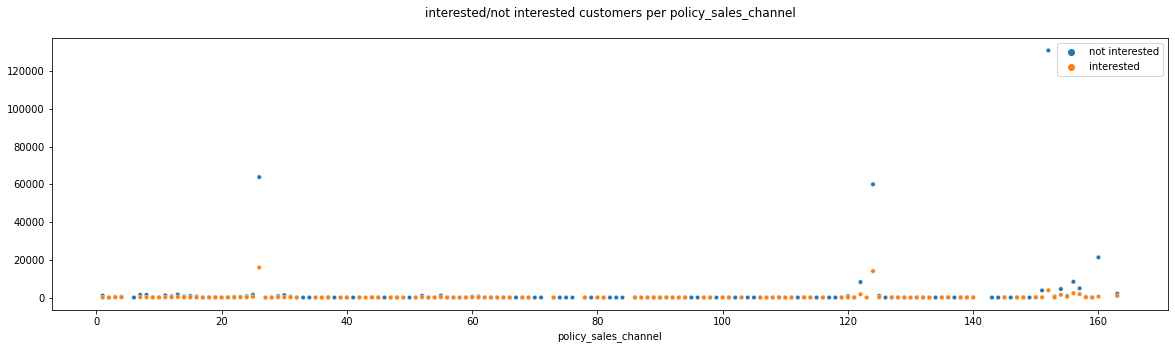

In [48]:
aux = df4[['policy_sales_channel', 'id', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
aux['response'] = aux['response'].map({0:'not interested', 1:'interested'})
plt.figure(figsize=(20,5))
ax = sns.scatterplot(x='policy_sales_channel', y = 'id', hue = 'response', data = aux, s=20)
ax.set_title('interested/not interested customers per policy_sales_channel\n')
ax.legend(title='')
ax.set_ylabel('');

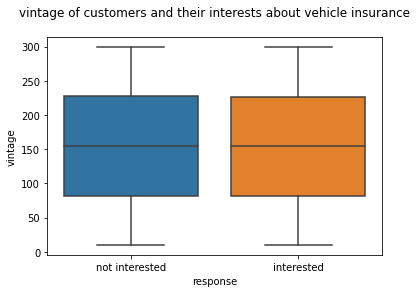

In [49]:
#'vintage'
ax = sns.boxplot(x = 'response', y= 'vintage', data = df4)
ax.set_xticklabels(['not interested', 'interested']);
ax.set_title('vintage of customers and their interests about vehicle insurance\n');

# 5.0. Data Preparation

In [31]:
df5 = df4.copy()

In [32]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [34]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
#df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
#pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

# Age - MinMaxScaler
#df5['age'] = ss.fit_transform( df5[['age']].values )


# Vintage - MinMaxScaler
#df5['vintage'] = ss.fit_transform( df5[['vintage']].values )

## 5.2 Rescaling

In [35]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
mms_annual = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
#pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

# Annual Premium - MinMaxScaler
df5['annual_premium'] = mms_annual.fit_transform( df5[['annual_premium']].values )
pickle.dump( mms_annual, open( '../src/features/annual_premium_scaler2.pkl', 'wb' ) )

## 5.3 Transformation

### 5.3.1 Encoding

In [36]:
 # gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )
#df5['gender'] = df5['gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
df5['vehicle_age_below_1_year']=df5['vehicle_age_below_1_year'].astype(int)
df5['vehicle_age_between_1_2_year']=df5['vehicle_age_between_1_2_year'].astype(int)
df5['vehicle_age_over_2_years']=df5['vehicle_age_over_2_years'].astype(int)


# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

In [110]:
df5.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
response                        0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

## 5.4 Validation Preparation

In [37]:
# gender
#x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )
x_validation.loc[:, 'gender'] = x_validation.loc[:,'gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )
#x_validation.loc[:, 'age'] = ss.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )
x_validation['vehicle_age_below_1_year']=x_validation['vehicle_age_below_1_year'].astype(int)
x_validation['vehicle_age_between_1_2_year']=x_validation['vehicle_age_between_1_2_year'].astype(int)
x_validation['vehicle_age_over_2_years']=x_validation['vehicle_age_over_2_years'].astype(int)

# annual_premium
#x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )
x_validation.loc[:, 'annual_premium'] = mms_annual.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )
#x_validation.loc[:, 'vintage'] = ss.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

## 6.1 Boruta Algorithm

In [71]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [74]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2 Feature Importance

In [18]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.274412
0                annual_premium    0.244899
0                           age    0.165077
0                   region_code    0.105011
0                vehicle_damage    0.067947
0          policy_sales_channel    0.058799
0            previously_insured    0.056382
0      vehicle_age_below_1_year    0.013880
0  vehicle_age_between_1_2_year    0.006116
0                        gender    0.004694
0      vehicle_age_over_2_years    0.002295
0               driving_license    0.000488


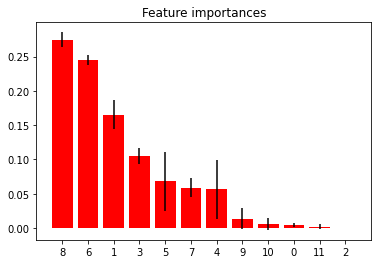

In [23]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Model

In [38]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years', 'gender' ]

cols_full = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years', 'gender',  'response']

In [132]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

In [40]:
df7 = df5[cols_full]

## 7.1 KNN Classifier

In [123]:
params = {
    'n_neighbors':  [3,5,8,15],
    'weights':  ['uniform', 'distance'], 
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20,30,40],
    'p': [1,2]
}
MAX_EVAL = 5

NameError: name 'warnings' is not defined

In [124]:
knn_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    knn_model =  nh.KNeighborsClassifier( n_neighbors = hp['n_neighbors'],
                                          weights = hp['weights'],
                                          algorithm= hp['algorithm'],
                                          leaf_size= hp['leaf_size'],
                                          p = hp['p'])
         
    knn_cv = cross_validation(df7, knn_model,'KNN Classifier - '+str(i),5,2,20000)
    
    knn_m = knn_m.append(knn_cv)
    print(knn_m)
    
    
knn_m

C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


{'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 20, 'p': 2}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_m = knn_m.append(knn_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                   Mean_Precision_at_k  Mean_Recall_at_k
KNN Classifier - 0   0.29347+/-0.00143  0.78418+/-0.0038
{'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_m = knn_m.append(knn_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0   0.29347+/-0.00143   0.78418+/-0.0038
KNN Classifier - 1   0.28011+/-0.00157  0.74848+/-0.00422
{'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_m = knn_m.append(knn_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0   0.29347+/-0.00143   0.78418+/-0.0038
KNN Classifier - 1   0.28011+/-0.00157  0.74848+/-0.00422
KNN Classifier - 2   0.27412+/-0.00129  0.73248+/-0.00343
{'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_m = knn_m.append(knn_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0   0.29347+/-0.00143   0.78418+/-0.0038
KNN Classifier - 1   0.28011+/-0.00157  0.74848+/-0.00422
KNN Classifier - 2   0.27412+/-0.00129  0.73248+/-0.00343
KNN Classifier - 3   0.29383+/-0.00125  0.78514+/-0.00334
{'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 40, 'p': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0   0.29347+/-0.00143   0.78418+/-0.0038
KNN Classifier - 1   0.28011+/-0.00157  0.74848+/-0.00422
KNN Classifier - 2   0.27412+/-0.00129  0.73248+/-0.00343
KNN Classifier - 3   0.29383+/-0.00125  0.78514+/-0.00334
KNN Classifier - 4   0.28058+/-0.00116  0.74973+/-0.00306


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\1091922542.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  knn_m = knn_m.append(knn_cv)


,Mean_Precision_at_k,Mean_Recall_at_k
KNN Classifier - 0,0.29347+/-0.00143,0.78418+/-0.0038
KNN Classifier - 1,0.28011+/-0.00157,0.74848+/-0.00422
KNN Classifier - 2,0.27412+/-0.00129,0.73248+/-0.00343
KNN Classifier - 3,0.29383+/-0.00125,0.78514+/-0.00334
KNN Classifier - 4,0.28058+/-0.00116,0.74973+/-0.00306


In [69]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat = knn_model.predict(x_val)
    mean_rcc[n-1] = balanced_accuracy_score(y_validation, yhat)

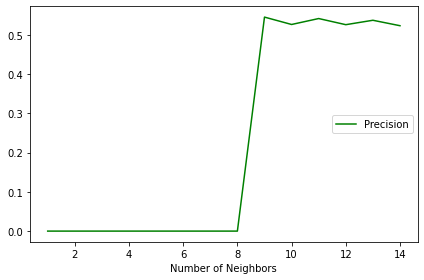

In [70]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [71]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

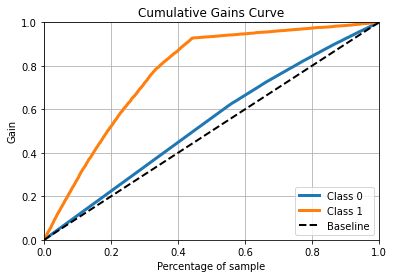

In [72]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

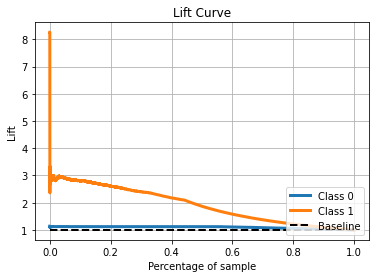

In [73]:
 #Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2 Logistic Regression

In [44]:
params = {
    'penalty':  ['l2', 'none'],
    'C':  [0.5, 1, 10, 100], 
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'class_weight': [None, 'balanced']
}

MAX_EVAL = 5

In [46]:
lr_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    lr_model =  lm.LogisticRegression( penalty = hp['penalty'],
                                       C= hp['C'],
                                       solver= hp['solver'],
                                       class_weight= hp['class_weight'],
                                     )
         
    lr_cv = cross_validation(df7 , lr_model,'Logistic Regression - '+str(i),5,2,20000)
    
    lr_m = lr_m.append(lr_cv)
    print(lr_m)
    
    
lr_m

C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


{'penalty': 'none', 'C': 1, 'solver': 'lbfgs', 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_m = lr_m.append(lr_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ig

                        Mean_Precision_at_k  Mean_Recall_at_k
Logistic Regression - 0   0.29587+/-0.00076  0.7891+/-0.00202
{'penalty': 'l2', 'C': 0.5, 'solver': 'newton-cg', 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_m = lr_m.append(lr_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                        Mean_Precision_at_k  Mean_Recall_at_k
Logistic Regression - 0   0.29587+/-0.00076  0.7891+/-0.00202
Logistic Regression - 1   0.29594+/-0.00215   0.7893+/-0.0057
{'penalty': 'l2', 'C': 1, 'solver': 'newton-cg', 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_m = lr_m.append(lr_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                        Mean_Precision_at_k  Mean_Recall_at_k
Logistic Regression - 0   0.29587+/-0.00076  0.7891+/-0.00202
Logistic Regression - 1   0.29594+/-0.00215   0.7893+/-0.0057
Logistic Regression - 2   0.29586+/-0.00133  0.7891+/-0.00356
{'penalty': 'l2', 'C': 1, 'solver': 'sag', 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_m = lr_m.append(lr_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                        Mean_Precision_at_k   Mean_Recall_at_k
Logistic Regression - 0   0.29587+/-0.00076   0.7891+/-0.00202
Logistic Regression - 1   0.29594+/-0.00215    0.7893+/-0.0057
Logistic Regression - 2   0.29586+/-0.00133   0.7891+/-0.00356
Logistic Regression - 3    0.29583+/-0.0021  0.78902+/-0.00558
{'penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None}

KFold Number: 1


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 2


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 3


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 4


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 5


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 6


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 7


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 8


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 9


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



KFold Number: 10
                        Mean_Precision_at_k   Mean_Recall_at_k
Logistic Regression - 0   0.29587+/-0.00076   0.7891+/-0.00202
Logistic Regression - 1   0.29594+/-0.00215    0.7893+/-0.0057
Logistic Regression - 2   0.29586+/-0.00133   0.7891+/-0.00356
Logistic Regression - 3    0.29583+/-0.0021  0.78902+/-0.00558
Logistic Regression - 4   0.29582+/-0.00168  0.78899+/-0.00449


C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3426623785.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_m = lr_m.append(lr_cv)


,Mean_Precision_at_k,Mean_Recall_at_k
Logistic Regression - 0,0.29587+/-0.00076,0.7891+/-0.00202
Logistic Regression - 1,0.29594+/-0.00215,0.7893+/-0.0057
Logistic Regression - 2,0.29586+/-0.00133,0.7891+/-0.00356
Logistic Regression - 3,0.29583+/-0.0021,0.78902+/-0.00558
Logistic Regression - 4,0.29582+/-0.00168,0.78899+/-0.00449


In [47]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

#print('Accuracy Score: '   + str(accuracy_score( y_val, yhat_lr)))
#print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_val, yhat_lr)))

C:\Users\kaka\anaconda3\envs\health_insurance_class\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


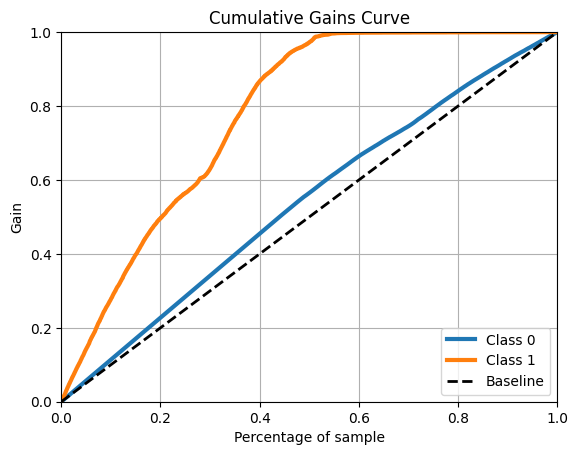

In [48]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

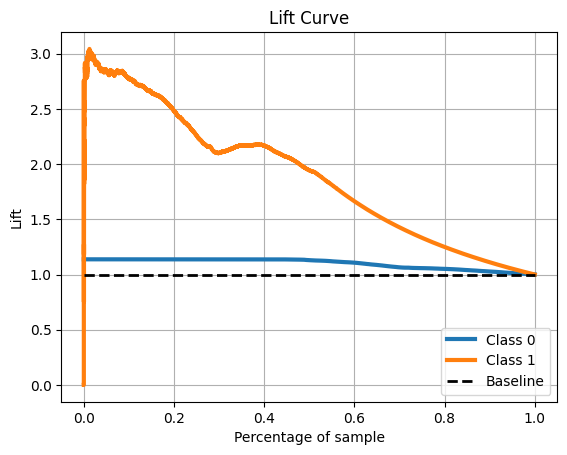

In [49]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 Extra trees Classifier

In [50]:
params = { 'n_estimators':[250,500,750],
           'max_depth':[3,5,7],
           'min_samples_split':  [2,3],
           'min_samples_leaf': [1,2],
           'class_weight': [None, 'balanced','balanced_subsample']
}

MAX_EVAL = 5

In [51]:
et_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    et_model = en.ExtraTreesClassifier(n_estimators = hp['n_estimators'],
                                       max_depth = hp['max_depth'],
                                       min_samples_split= hp['min_samples_split'],
                                       min_samples_leaf= hp['min_samples_leaf'],
                                       class_weight = hp['class_weight'],
                                       random_state = 25,
                                       n_jobs=-1)
         
    et_cv = cross_validation(df7,et_model,'Extra Trees Classifier - '+str(i),5,2,20000)
    
    et_m = et_m.append(et_cv)
    print(et_m)
    
    
et_m

C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


{'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  et_m = et_m.append(et_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0   0.30246+/-0.00085  0.80669+/-0.00226
{'n_estimators': 750, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  et_m = et_m.append(et_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0   0.30246+/-0.00085  0.80669+/-0.00226
Extra Trees Classifier - 1   0.29654+/-0.00122  0.79091+/-0.00326
{'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  et_m = et_m.append(et_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0   0.30246+/-0.00085  0.80669+/-0.00226
Extra Trees Classifier - 1   0.29654+/-0.00122  0.79091+/-0.00326
Extra Trees Classifier - 2   0.29756+/-0.00142  0.79363+/-0.00379
{'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  et_m = et_m.append(et_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0   0.30246+/-0.00085  0.80669+/-0.00226
Extra Trees Classifier - 1   0.29654+/-0.00122  0.79091+/-0.00326
Extra Trees Classifier - 2   0.29756+/-0.00142  0.79363+/-0.00379
Extra Trees Classifier - 3    0.30258+/-0.0013    0.807+/-0.00346
{'n_estimators': 750, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0   0.30246+/-0.00085  0.80669+/-0.00226
Extra Trees Classifier - 1   0.29654+/-0.00122  0.79091+/-0.00326
Extra Trees Classifier - 2   0.29756+/-0.00142  0.79363+/-0.00379
Extra Trees Classifier - 3    0.30258+/-0.0013    0.807+/-0.00346
Extra Trees Classifier - 4   0.29732+/-0.00158  0.79299+/-0.00

C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3876251504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  et_m = et_m.append(et_cv)


,Mean_Precision_at_k,Mean_Recall_at_k
Extra Trees Classifier - 0,0.30246+/-0.00085,0.80669+/-0.00226
Extra Trees Classifier - 1,0.29654+/-0.00122,0.79091+/-0.00326
Extra Trees Classifier - 2,0.29756+/-0.00142,0.79363+/-0.00379
Extra Trees Classifier - 3,0.30258+/-0.0013,0.807+/-0.00346
Extra Trees Classifier - 4,0.29732+/-0.00158,0.79299+/-0.00419


In [52]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

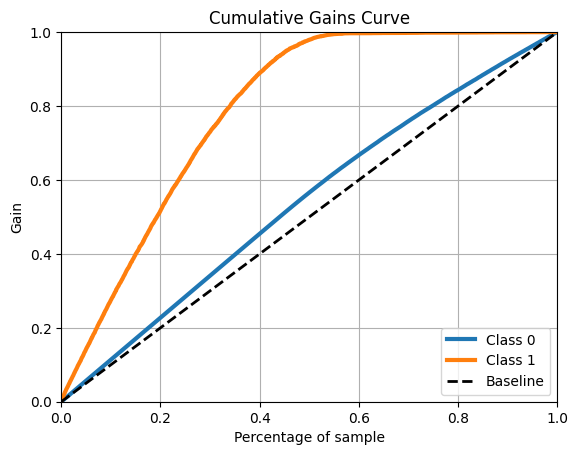

In [53]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

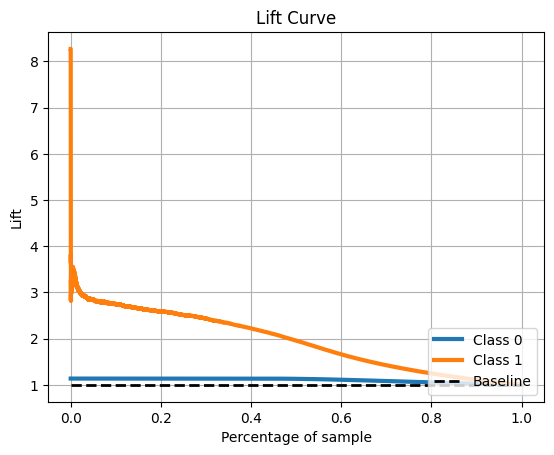

In [54]:
 #Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4 Random Forest

In [55]:
params = { 'n_estimators':[250,500,750],
           'max_depth':[3,5,7],
           'min_samples_split':[2,3],
           'min_samples_leaf': [1,2],
           'class_weight': [None, 'balanced','balanced_subsample']
}

MAX_EVAL = 5

In [58]:
rfc_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    rfc_model = en.RandomForestClassifier(n_estimators = hp['n_estimators'],
                                       max_depth = hp['max_depth'],
                                       min_samples_split= hp['min_samples_split'],
                                       min_samples_leaf= hp['min_samples_leaf'],
                                       class_weight = hp['class_weight'],
                                       random_state = 35,
                                       n_jobs=-1)
         
    rfc_cv = cross_validation(df7,rfc_model,'Random Forest Classifier - '+str(i), 5,2,20000)
    
    rfc_m = rfc_m.append(rfc_cv)
    print(rfc_m)
    
    
rfc_m

C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


{'n_estimators': 250, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rfc_m = rfc_m.append(rfc_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                             Mean_Precision_at_k   Mean_Recall_at_k
Random Forest Classifier - 0   0.30607+/-0.00102  0.81632+/-0.00269
{'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rfc_m = rfc_m.append(rfc_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                             Mean_Precision_at_k   Mean_Recall_at_k
Random Forest Classifier - 0   0.30607+/-0.00102  0.81632+/-0.00269
Random Forest Classifier - 1   0.30851+/-0.00097  0.82282+/-0.00259
{'n_estimators': 750, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rfc_m = rfc_m.append(rfc_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                             Mean_Precision_at_k   Mean_Recall_at_k
Random Forest Classifier - 0   0.30607+/-0.00102  0.81632+/-0.00269
Random Forest Classifier - 1   0.30851+/-0.00097  0.82282+/-0.00259
Random Forest Classifier - 2   0.30844+/-0.00134  0.82265+/-0.00355
{'n_estimators': 250, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rfc_m = rfc_m.append(rfc_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                             Mean_Precision_at_k   Mean_Recall_at_k
Random Forest Classifier - 0   0.30607+/-0.00102  0.81632+/-0.00269
Random Forest Classifier - 1   0.30851+/-0.00097  0.82282+/-0.00259
Random Forest Classifier - 2   0.30844+/-0.00134  0.82265+/-0.00355
Random Forest Classifier - 3   0.29392+/-0.00178  0.78391+/-0.00477
{'n_estimators': 750, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                             Mean_Precision_at_k   Mean_Recall_at_k
Random Forest Classifier - 0   0.30607+/-0.00102  0.81632+/-0.00269
Random Forest Classifier - 1   0.30851+/-0.00097  0.82282+/-0.00259
Random Forest Classifier - 2   0.30844+/-0.00134  0.82265+/-0.00355
Random Forest Classifier - 3   0.29392+/-0.00178  0.78391+/-0.00477
Random Forest Classifier -

C:\Users\kaka\AppData\Local\Temp\ipykernel_11348\3565524971.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rfc_m = rfc_m.append(rfc_cv)


,Mean_Precision_at_k,Mean_Recall_at_k
Random Forest Classifier - 0,0.30607+/-0.00102,0.81632+/-0.00269
Random Forest Classifier - 1,0.30851+/-0.00097,0.82282+/-0.00259
Random Forest Classifier - 2,0.30844+/-0.00134,0.82265+/-0.00355
Random Forest Classifier - 3,0.29392+/-0.00178,0.78391+/-0.00477
Random Forest Classifier - 4,0.29432+/-0.00141,0.78498+/-0.00376


In [59]:
# model definition
rf = en.RandomForestClassifier( n_estimators=250, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

#'n_estimators': 250, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'class_weight': None

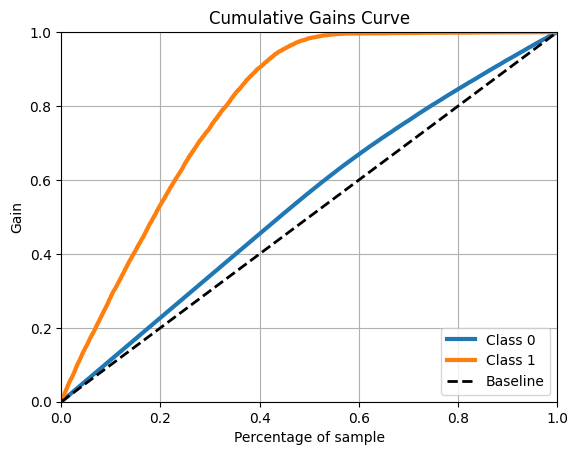

In [60]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

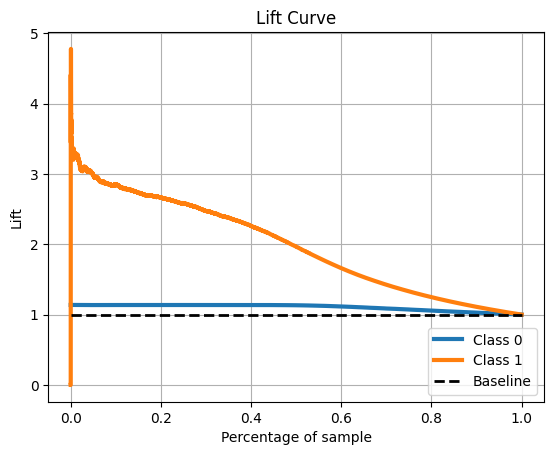

In [61]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

## 7.5 XGBoost

In [115]:
params = { 'n_estimators':  [100, 200, 300, 400, 500],
           'max_depth': [3,5,9], 
           'scale_pos_weight': [1,7.15, 100]
}

MAX_EVAL = 5

In [119]:
xgb_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    xgb_model = xgb.XGBClassifier(  objective='binary:logistic',
                                    n_estimators = hp['n_estimators'],
                                    max_depth = hp['max_depth'],
                                    scale_pos_weight = hp['scale_pos_weight'],
                                    n_jobs=-1)
         
    xgb_cv = cross_validation(df7,xgb_model,'XGBoost Classifier - '+str(i),5,2,20000)
    
    xgb_m = xgb_m.append(xgb_cv)
    print(xgb_m)
    
    
xgb_m

C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


{'n_estimators': 500, 'max_depth': 9, 'scale_pos_weight': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_m = xgb_m.append(xgb_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0   0.29864+/-0.00178  0.79799+/-0.00477
{'n_estimators': 200, 'max_depth': 5, 'scale_pos_weight': 7.15}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_m = xgb_m.append(xgb_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0   0.29864+/-0.00178  0.79799+/-0.00477
XGBoost Classifier - 1   0.30914+/-0.00149  0.82606+/-0.00401
{'n_estimators': 200, 'max_depth': 9, 'scale_pos_weight': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_m = xgb_m.append(xgb_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0   0.29864+/-0.00178  0.79799+/-0.00477
XGBoost Classifier - 1   0.30914+/-0.00149  0.82606+/-0.00401
XGBoost Classifier - 2   0.30366+/-0.00105  0.81142+/-0.00279
{'n_estimators': 300, 'max_depth': 3, 'scale_pos_weight': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_m = xgb_m.append(xgb_cv)
C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hp_list = hp_list.append(hp,ignore_index=True)


                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0   0.29864+/-0.00178  0.79799+/-0.00477
XGBoost Classifier - 1   0.30914+/-0.00149  0.82606+/-0.00401
XGBoost Classifier - 2   0.30366+/-0.00105  0.81142+/-0.00279
XGBoost Classifier - 3   0.31127+/-0.00113  0.83174+/-0.00301
{'n_estimators': 100, 'max_depth': 5, 'scale_pos_weight': 100}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0   0.29864+/-0.00178  0.79799+/-0.00477
XGBoost Classifier - 1   0.30914+/-0.00149  0.82606+/-0.00401
XGBoost Classifier - 2   0.30366+/-0.00105  0.81142+/-0.00279
XGBoost Classifier - 3   0.31127+/-0.00113  0.83174+/-0.00301
XGBoost Classifier - 4   0.30923+/-0.00139  0.82629+/-0.00367


C:\Users\kaka\AppData\Local\Temp\ipykernel_7044\3241239839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_m = xgb_m.append(xgb_cv)


,Mean_Precision_at_k,Mean_Recall_at_k
XGBoost Classifier - 0,0.29864+/-0.00178,0.79799+/-0.00477
XGBoost Classifier - 1,0.30914+/-0.00149,0.82606+/-0.00401
XGBoost Classifier - 2,0.30366+/-0.00105,0.81142+/-0.00279
XGBoost Classifier - 3,0.31127+/-0.00113,0.83174+/-0.00301
XGBoost Classifier - 4,0.30923+/-0.00139,0.82629+/-0.00367


In [64]:
# model definition
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              random_state=17,
                              n_jobs=-1,
                              max_depth = 5,
                              n_estimators=300)

#model training
model_xgb.fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict_proba( x_val )

#metrics 
#print('Accuracy Score: '   + str(accuracy_score( y_val, yhat_xgb)))
#print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_val, yhat_xgb)))

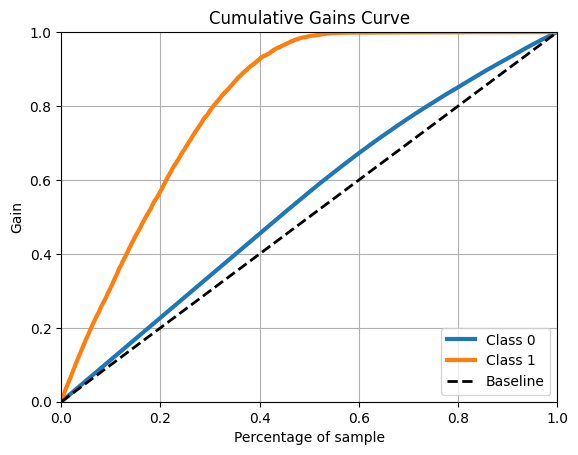

In [65]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );

## 7.6 Results Model - Cross Validation

In [71]:
precision_final_results = {'model':['KNN', 'L_Regression', 'XGB', 'R_Forest', 'E_Trees'],
                 'precision_at_k': ['0.29383+/-0.00125',
                                    '0.29582+/-0.00168',
                                    '0.31127+/-0.00113',
                                    '0.30844+/-0.00134',
                                    '0.30258+/-0.0013'],
                 'parameters': ["'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'ball_tree'",
                                "penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None",
                                "'n_estimators': 100, 'max_depth': 5, 'scale_pos_weight': 1",
                                "'n_estimators': 750, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None",
                                "'n_estimators': 300, 'max_depth': 3, 'scale_pos_weight': 1"]
                }

print(tabulate(precision_final_results, headers=['model','precision@k', 'hyperparameters'], tablefmt="fancy_grid"))

╒══════════════╤═══════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ model        │ precision@k       │ hyperparameters                                                                                          │
╞══════════════╪═══════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ KNN          │ 0.29383+/-0.00125 │ 'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'ball_tree'                                        │
├──────────────┼───────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ L_Regression │ 0.29582+/-0.00168 │ penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None                                        │
├──────────────┼───────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────

In [72]:
recall_final_results = {'model':['KNN', 'L_Regression', 'XGB', 'R_Forest', 'E_Trees'],
                 'recall_at_k': ['0.78514+/-0.00334',
                                 '0.78899+/-0.00449',
                                 '0.83174+/-0.00301',
                                 '0.82265+/-0.00355',
                                 '0.807+/-0.00346'],
                 'parameters': ["'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'ball_tree'",
                                "penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None",
                                "'n_estimators': 100, 'max_depth': 5, 'scale_pos_weight': 1",
                                "'n_estimators': 750, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': None",
                                "'n_estimators': 300, 'max_depth': 3, 'scale_pos_weight': 1"]
                }

print(tabulate(recall_final_results, headers=['model','recall@k', 'hyperparameters'], tablefmt="fancy_grid"))

╒══════════════╤═══════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ model        │ recall@k          │ hyperparameters                                                                                          │
╞══════════════╪═══════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ KNN          │ 0.78514+/-0.00334 │ 'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'ball_tree'                                        │
├──────────────┼───────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ L_Regression │ 0.78899+/-0.00449 │ penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None                                        │
├──────────────┼───────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────

# 8.0 Perfomance Metrics

In [129]:
def precision_at_k( data, k=20000 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

In [130]:
 def recall_at_k( data, k=20000 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [75]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_200, data = precision_at_k( df8, k= 20000 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=20000 )

In [25]:
precision_at_200

0.33808309584520774

In [76]:
recall_at_15

0.7133246527777778

In [78]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k=2)

0.75

In [79]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## Cumulative Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

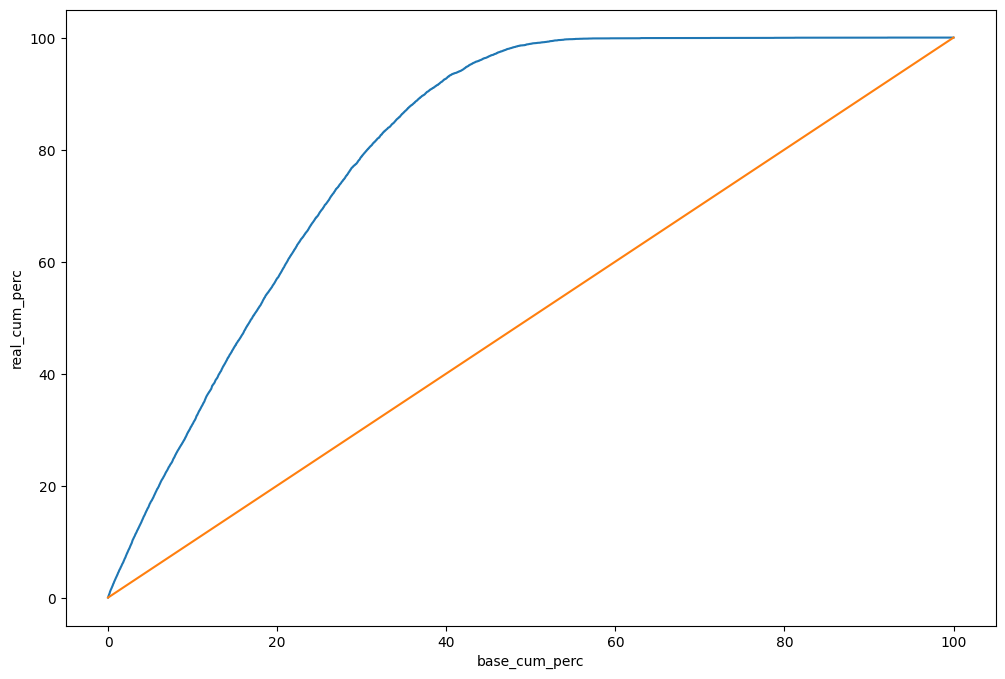

In [80]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## Lift Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

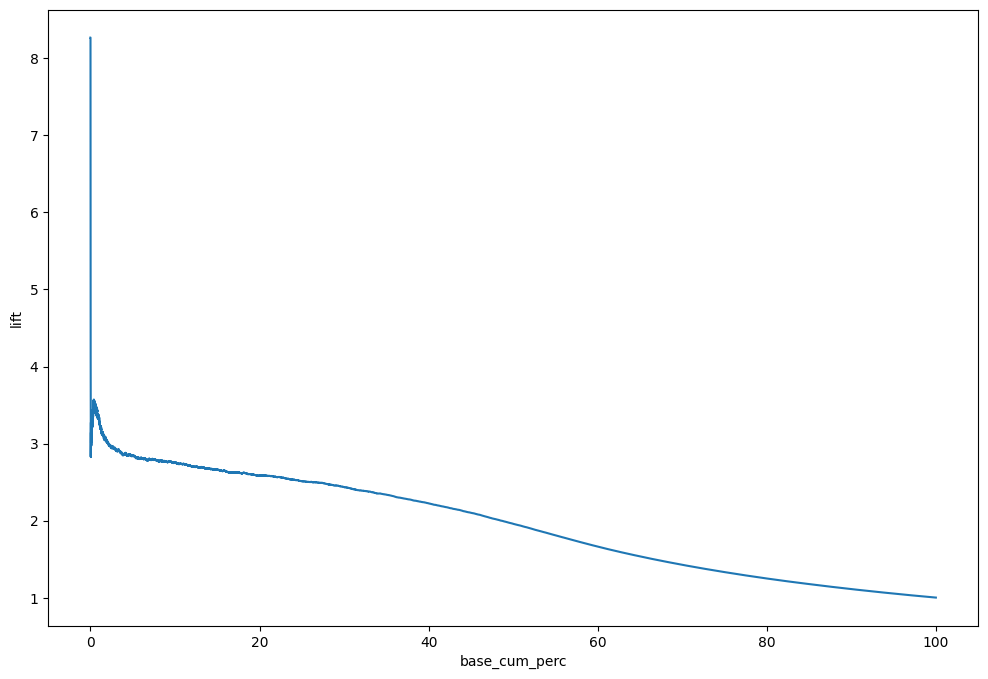

In [81]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## ROI Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

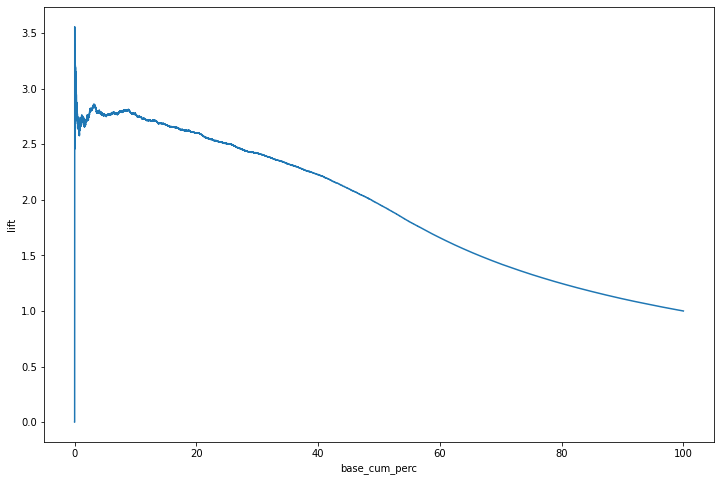

In [47]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve


plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [80]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
4,0.40,0.400050,1970,31523.974001,1.600202,1.000000,31522.373800
3,0.30,0.300001,11330,135960.545659,1.200005,0.600404,135959.345654
2,0.20,0.200026,11381,91059.757344,0.800103,0.300744,91058.957240
1,0.10,0.100006,8511,34046.138756,0.400025,0.100945,34045.738731
0,0.01,0.001054,43030,1813.810364,0.004215,0.001053,1813.806148


<AxesSubplot:xlabel='base', ylabel='revenue'>

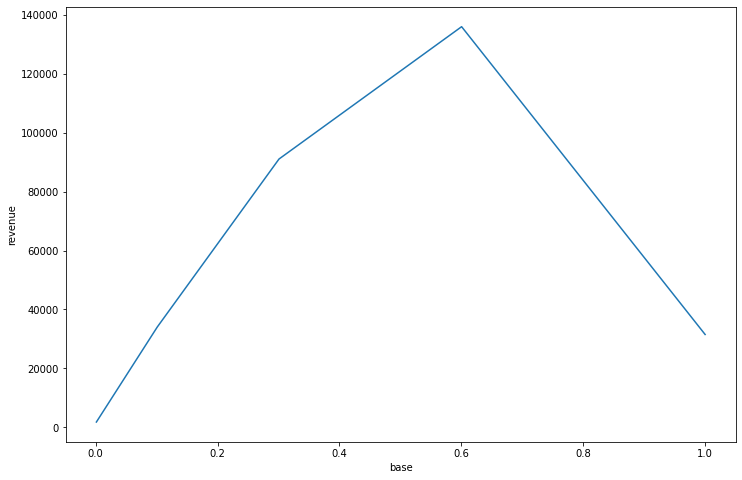

In [81]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

# 9.0 Bussines traduction

In [133]:
data = x_val.copy()

data['response'] = y_val.copy()
#data['score'] = yhat_nb[:, 1].tolist()
data['score'] = yhat_xgb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [144]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)
precision_at_20000=precision_at_k(data,k=20000)

print('Percent of Data: {}'.format(percent_of_dataset))
print('Recall at 20000: {}'.format(recall_at_20000[0]))
print('Precision at 20000: {}'.format(precision_at_20000[0]))

Percent of Data: 0.2623914355435439
Recall at 20000: 0.7133246527777778
Precision at 20000: 0.32868356582170893


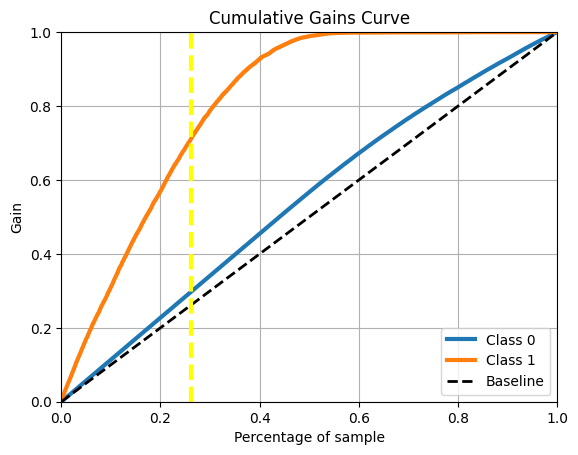

In [145]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

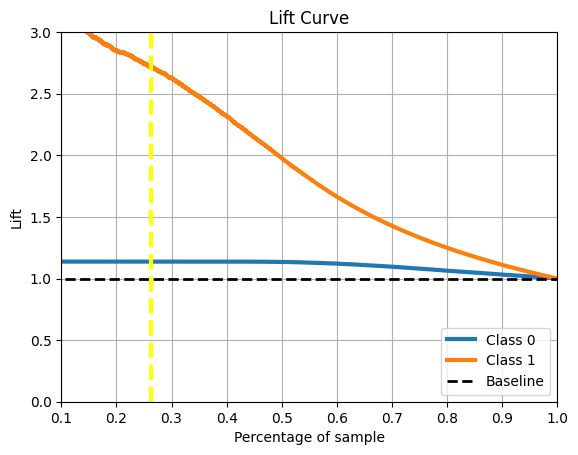

In [146]:
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

In [148]:
percent_of_dataset = 40000 / len(data)
recall_at_40000 = recall_at_k(data, k = 40000)
precision_at_40000=precision_at_k(data,k=40000)

print('Percent of Data: {}'.format(percent_of_dataset))
print('Recall at 40000: {}'.format(recall_at_40000[0]))
print('Precision at 40000: {}'.format(precision_at_40000[0]))

Percent of Data: 0.5247828710870878
Recall at 40000: 0.9938151041666666
Precision at 40000: 0.2289692757681058


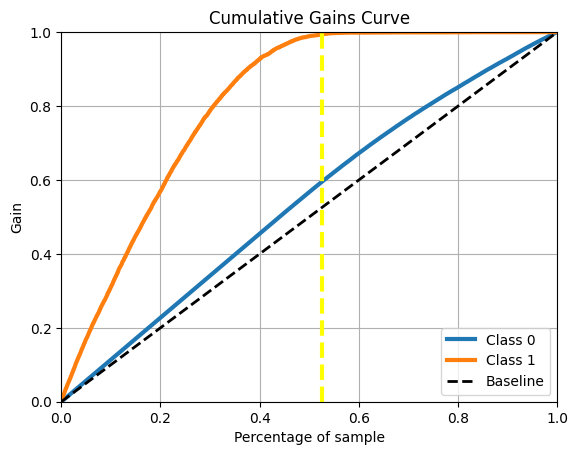

In [149]:
# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

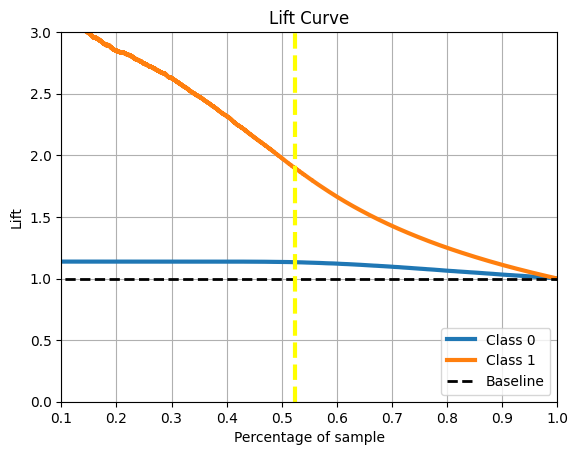

In [150]:
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb)
plt.axvline(percent_of_dataset, 0, 1, color='yellow', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3);

# 10.0 Model to deploy

In [111]:
# Save trained model
#pickle.dump( model_xgb, open( '../src/models/model_health_insurance.pkl', 'wb' ) )
#pickle.dump( lr_model, open( '../src/models/model_linear_regression.pkl', 'wb' ) )
#pickle.dump( model_xgb, open( '../src/models/model_xgb_.pkl', 'wb' ) )

## 10.1 Health Insurance Class

In [1]:
import pickle
import numpy  as np
import pandas as pd

class Insurance (object):
    
    def __init__( self ):
        self.home_path = 'C:/Usuários/kaka/Projetos_DS/health-insurance-cross-sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd

from flask               import Flask, request, Response
from insurance.Insurance import Insurance

# loading model
path = 'C:/Usuários/kaka/Projetos_DS/health-insurance-cross-sell/'
model = pickle.load( open( path + 'src/models/model_linear_regression.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/insurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '10.0.0.104', port=5000 )

## 10.3 API Test

In [1]:
import requests
import pandas as pd

In [15]:
#loading dataset
# loading test dataset
df_test = pd.read_csv('C:/Users/kaka/Projetos_DS/health-insurance-cross-sell/data/raw/test.csv')

In [16]:
data = json.dumps(df_test.to_dict(orient = 'records'))

In [17]:
# API Call
#url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-cross.herokuapp.com/predict'

header = {'Content-type':'application/json'}
r = requests.post(url,data,headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [18]:
ex = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [19]:
ex.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53,0.000761
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111,0.130544
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199,0.399186
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187,0.000269
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297,0.001691


In [20]:
export = ex.sort_values( 'score', ascending=False ).head(20)

In [21]:
export

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
99028,480138,Male,66,1,28.0,0,< 1 Year,Yes,48110.0,26.0,52,0.990919
27883,408993,Male,66,1,11.0,0,< 1 Year,Yes,38444.0,26.0,216,0.988797
8949,390059,Female,44,1,8.0,0,< 1 Year,Yes,45584.0,26.0,39,0.988748
102630,483740,Male,44,1,28.0,0,< 1 Year,Yes,57529.0,124.0,38,0.984719
23040,404150,Male,52,1,28.0,0,< 1 Year,Yes,46250.0,124.0,68,0.983921
82552,463662,Male,56,1,28.0,0,< 1 Year,Yes,52102.0,26.0,40,0.982233
57252,438362,Male,65,1,17.0,0,1-2 Year,Yes,47085.0,157.0,57,0.974472
28977,410087,Male,42,1,8.0,0,< 1 Year,Yes,34794.0,26.0,81,0.973941
72692,453802,Male,46,1,28.0,0,< 1 Year,Yes,52928.0,26.0,145,0.971951
9061,390171,Male,45,1,28.0,0,1-2 Year,Yes,52538.0,156.0,297,0.969453


In [21]:
export.to_excel('C:/Users/kaka/Projetos_DS/health-insurance-cross-sell/export.xlsx')

In [4]:
df_test.head(50).to_excel('C:/Users/kaka/Projetos_DS/health-insurance-cross-sell/df_teste.xlsx')

In [14]:
df_test.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object